# Importing necessary dependancies

In [0]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

# Scraping for Data retrieval

In [0]:
#list of urls from where we want to extract the data
seed_urls=['https://inshorts.com/en/read/technology',
          'https://inshorts.com/en/read/sports',
          'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
  news_data=[]
  for url in seed_urls:
    news_category=url.split('/')[-1]#Split by '/' character and last string from array
    data=requests.get(url)
    soup=BeautifulSoup(data.content,'html.parser')#Returns BeautifulSoup object
    #print(soup)
    #Extract the news headline,article text and category
    news_articles = [{'news_headline': headline.find('span', 
                                                          attrs={"itemprop": "headline"}).string,
                            'news_article': article.find('div', 
                                                        attrs={"itemprop": "articleBody"}).string,
                            'news_category': news_category}
                          
                              for headline, article in 
                              zip(soup.find_all('div', 
                                                class_=["news-card-title news-right-box"]),
                                  soup.find_all('div', 
                                                class_=["news-card-content news-right-box"]))]
    #print(news_articles)
    news_data.extend(news_articles)
    df=pd.DataFrame(news_data)
    df=df[['news_headline','news_article','news_category']]
  return df

In [5]:
news_df=build_dataset(seed_urls)
news_df.head(5)

,news_headline,news_article,news_category
0,Amazon says warehouse worker has coronavirus a...,An Amazon warehouse in the US confirmed its fi...,technology
1,No new emoji may be released in 2021 due to CO...,"The Unicode Consortium, the group behind emoji...",technology
2,IIT-Ropar develops device to sanitise currency...,"Indian Institute of Technology, Ropar has deve...",technology
3,Facebook sues Indian techie over deceptive ads...,Facebook has filed a lawsuit against an Indian...,technology
4,Facebook adds 'Quiet Mode' to help users spend...,"Facebook is launching a ""Quiet Mode"" on iOS to...",technology


In [6]:
news_df.news_category.value_counts()

technology    25
world         25
sports        23
Name: news_category, dtype: int64

# Text wraggling & Pre-processing

In [7]:
#Installing Spacy language model
import spacy.cli
spacy.cli.download("en_core_web_sm")
!pip install contractions


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 245kB 4.3MB/s 
     |████████████████████████████████| 317kB 8.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81701 sha256=1dd00ad333845e778168d631b88a4170244f18a6764031e3e4c4845588f83a4f
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [8]:
import spacy
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize.toktok import ToktokTokenizer
import re
import contractions
import unicodedata

nlp = spacy.load('en_core_web_sm', parse = True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Remove HTML tags

In [9]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

# Remove accented characters

In [10]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

# Expand contractions

In [11]:
def expand_contractions(text):
  return contractions.fix(text)

expand_contractions("Y'all can't expand contractions I'd think")

'you all can not expand contractions I would think'

# Remove special characters

In [12]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

# Text lemmatization

In [13]:
def lemmatize_text(text):
    text = nlp(text)
    #-PRON- is lemma for all personal pronoun
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

# Text stemming

In [14]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

# Remove stopwords

In [15]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

# Building a text normalizer

In [0]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

# Pre-process and normalize news articles

In [17]:
news_df['full_text']=news_df['news_headline']+ '. '+news_df['news_article']
print(news_df['full_text'][5])

Drones used to spray disinfectants over sealed hotspots in Noida. The Noida Authority has started using drones to spray disinfectants over some sealed coronavirus hotspots in the city. The authority has also installed two disinfectant tunnels for staff members, who are engaged in providing essential services to the public. These tunnels, which spray sodium hypochlorite solution, take around 30 seconds to disinfect a person who walks through it, officials said.


In [18]:
news_df['clean_text']=normalize_corpus(news_df['full_text'])
norm_corpus=list(news_df['clean_text'])
news_df.iloc[1][['full_text','clean_text']].to_dict()

{'clean_text': 'no new emoji may release due covid pandemic unicode consortium group behind emoji release announce due coronavirus pandemic delay release plan six month essentially mean emoji version likely roll however emoji announce earlier year include transgend flag italian hand gesture make available soon',
 'full_text': "No new emoji may be released in 2021 due to COVID-19 pandemic. The Unicode Consortium, the group behind emoji releases, has announced that due to coronavirus pandemic, it's delaying the release planned for 2021 by six months. This essentially means the emoji version will likely be rolled out in 2022. However, the emoji that were announced earlier this year, including the transgender flag and Italian hand gesture, will be made available soon."}

# Save the news articles

In [0]:
news_df.to_csv('news.csv',index=False,encoding='utf-8')

Knowledge about the structure and syntax of language is helpful in many areas like **text processing**,**annotation**, and **parsing** for further operations such as **text classification** or **summarization**.


Typical Parsing techniques for understanding text syntax:
*   Parts of Speech (POS) Tagging
*   Shallow Parsing or Chunking
*   Constituency Parsing
*   Dependency Parsing



A sentence typically follows a hieararchical structure consisting the following components.

## sentence → clauses → phrases → words

## Tagging Parts of speech
N(oun)

V(erb)

Adj(ective)

Adv(erb)

PRON(OUN)

NN(Singular Nouns)

NNP(Singular proper Nouns)

(NNS)Plural Nouns

(DT)Optional determiner

The process of classifying and labeling POS tags for words called *Parts of Speech Tagging* or *POS tagging*

## nlp():
nlp() is used to store spaCy's pipeline. In this this variable spaCy
loads its models and data,Here we invoke nlp on sentence to create a 
*sentence_nlp* object.This *sentence_nlp* object is now a vessel for NLP
tasks on the text itself

Many of Spacy's token methos offer both string and integer representations of processed text
- Methods with an underscore suffix return strings
- Without an underscore return integers

In [46]:
#Create a basic pre processed corpus,Don't lowercase to get POS context
corpus=normalize_corpus(news_df['full_text'],text_lower_case=False,
                        text_lemmatization=False,special_char_removal=False)

#demo for POS tagging for sample news headline
sentence=str(news_df.iloc[1].news_headline)
print(sentence)
sentence_nlp=nlp(sentence)


#POS tagging with spacy
spacy_pos_tagged=[(word,word.tag_,word.pos_) for word in sentence_nlp]

# We can get more details about any POS tag using help funciton of NLTK as follows.
'''
nltk.download('tagsets')
nltk.help.upenn_tagset("DT")
'''
pd.DataFrame(spacy_pos_tagged,columns=['word','POS tag','Tag type'])

No new emoji may be released in 2021 due to COVID-19 pandemic


,word,POS tag,Tag type
0,No,DT,DET
1,new,JJ,ADJ
2,emoji,NNS,NOUN
3,may,MD,VERB
4,be,VB,AUX
5,released,VBN,VERB
6,in,IN,ADP
7,2021,CD,NUM
8,due,IN,ADP
9,to,IN,ADP


In [21]:
#POS tagging with nltk
nltk_pos_tagged=nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged,columns=['word','POS tag'])

,word,POS tag
0,No,DT
1,new,JJ
2,emoji,NN
3,may,MD
4,be,VB
5,released,VBN
6,in,IN
7,2021,CD
8,due,JJ
9,to,TO


##Shallow Parsing or Chunking or light parsing
Groups of words make up phrases.There are five major categories
- Noun Phrase (NP)
- Verb phrase (VP)
- Adjective phrase (ADJP)
- Adverb phrase (ADVP)
- Prepositional phrase (PP)



conll2000 corpus defines the chunks using IOB tags.
- It specifies where the chunk begins and end, along with its types.
- A POS tagger can be trained on these IOB tags

In [22]:
#Here conll2000 corpus for training shallow parser model

nltk.download('conll2000')
from nltk.corpus import conll2000

data= conll2000.chunked_sents()
train_data=data[:10900]
test_data=data[10900:]

print(len(train_data),len(test_data))
print(train_data[1])

[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


## Creating the chunker class for training

https://www.geeksforgeeks.org/nlp-training-tagger-based-chunker-set-1/?ref=rp
https://www.geeksforgeeks.org/nlp-training-tagger-based-chunker-set-2/?ref=rp

To train a chunker is an `alternative` to manually specifying regular expression(regex) chunk patterns

tree2conlltags,conlltags2tree are chunking utility functions.

- **tree2conlltags** , to get triples of (word,tag,chunk tags for each token)
This tuples are then finally used to train a tagger. and it learns IOB tags for POS tags.
- **conlltags2tree** to generate a parse tree from these token triples

*Conlltags2tree() is reversal of tree2conlltags()*

We'll be using these functions to train our parser

The chunk tags use the IOB format.

**IOB : Inside,Outside,Beginning**

B- prefix before a tag indicates ,it's the begining of a chunk

I- prefix indicates that it's inside a chunk

O- tag indicates the token doesn't belong to any chunk


In [23]:
from nltk.chunk.util import tree2conlltags,conlltags2tree

wtc=tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [24]:
tree=conlltags2tree(wtc)
print(tree)

(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


### Pre-requisite for Chunker class

In [0]:
'''
-> 3-tuples are then converted into 2-tuples that the tagger can recognize.
-> conll_tag_chunks() function takes 3-tuples (word, pos, iob) and returns 
a list of 2-tuples of the form (pos, iob)
'''
#To extract POS and chunk tags from sentence with chunked annotation
def conll_tag_chunks(chunk_sents):
  tagged_sents=[tree2conlltags(tree) for tree in chunk_sents]
  return [[(t,c) for (w,t,c) in sent] for sent in tagged_sents]


#To train multiple taggers with backoff taggers(e.g. unigram and bigram taggers)
def combined_tagger(train_data,taggers,backoff=None):
  for tagger in taggers:
    backoff=tagger(train_data,backoff=backoff)
  return backoff


## What is Tagger?
It reads text and assigns POS tag to each word.(Word,tag)

**Unigram Tagger** : For determining the POS, It only uses a single word.(Single word context-based tagger)


We will now define a class `NGramTagChunker` that will take in tagged sentences as training input, get their **(word,POS tag,Chunk tag)WTC triples** nd train a `BigramTagger` with a `UnigramTagger` as the backoff tagger.

We'll also define a parse() function to perform shallow parsing on new sentences

The `UnigramTagger` , `BigramTagger`, and `TrigramTagger` are classes that inherit from the base class `NGramTagger`, which itself inherits from the `ContextTagger` class, which inherits from the `SequentialBackoffTagger` class

In [26]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

#Define the chunker class
class NGramTagChunker(ChunkParserI):
  def __init__(self,train_sentences,tagger_classes=[UnigramTagger,BigramTagger]):
    train_sent_tags=conll_tag_chunks(train_sentences)
    self.chunk_tagger=combined_tagger(train_sent_tags,tagger_classes)

  def parse(self,tagged_sentence):
    if not tagged_sentence:
      return None
    pos_tags=[tag for word, tag in tagged_sentence]
    chunk_pos_tags=self.chunk_tagger.tag(pos_tags)
    chunk_tags=[chunk_tag for (pos_tag,chunk_tag) in chunk_pos_tags]
    wpc_tags=[(word,pos_tag,chunk_tag) for ((word,pos_tag),chunk_tag) in zip(tagged_sentence,chunk_tags)]
    return conlltags2tree(wpc_tags)

#train chunker model
ntc=NGramTagChunker(train_data)

#evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


Now leverage this model to shallow parse and chunk our sample news article headline.

In [27]:
chunk_tree=ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP No/DT new/JJ emoji/NN)
  (VP may/MD be/VB released/VBN)
  (PP in/IN)
  (NP 2021/CD due/JJ)
  (VP to/TO)
  (NP COVID-19/JJ pandemic/NN))


In [28]:
'''from spacy import displacy
displacy.render(chunk_tree, jupyter=True, options={'distance': 90})'''
'''

from IPython.display import display

path_to_gs='C:\\Program Files\\gs\\gs9.52\\bin'
os.environ['PATH']+=os.pathsep + path_to_gs
display(chunk_tree)'''

"\n\nfrom IPython.display import display\n\npath_to_gs='C:\\Program Files\\gs\\gs9.52\\bin'\nos.environ['PATH']+=os.pathsep + path_to_gs\ndisplay(chunk_tree)"

## Constituency Parsing

Constituent -based grammers are used to analyze and determine the constitute of a sentence.These grammers can be used to model or represnt the internal structure of sentences in terms of a hierarchically ordered structure of their constituents.

A constituency parser can be built based on grammer/rules , which are usually available as ontext-free grammer(CFG) or phase structured grammer.

Here,We'll be using `nltk` and the `stanfordParser`.

The Stanford parser generally uses a `PCFG (probabilistic context-free grammar)` parser.

A PCFG is a context-free grammar that associates a probability with each of its production rules. 

In [29]:
'''
from nltk.parse.stanford import StanfordDependencyParser
sdp=StanfordDependencyParser(path_to_jar='D:\stanford-parser-full-2018-10-17\stnford-parser.jar')
result=list(scp.raw_parse(sentence))
print(result[0])
'''

"\nfrom nltk.parse.stanford import StanfordDependencyParser\nsdp=StanfordDependencyParser(path_to_jar='D:\\stanford-parser-full-2018-10-17\\stnford-parser.jar')\nresult=list(scp.raw_parse(sentence))\nprint(result[0])\n"

## Dependency Parsing

In [30]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---No[det]--->[]
--------
[]<---new[amod]--->[]
--------
['No', 'new']<---emoji[nsubjpass]--->[]
--------
[]<---may[aux]--->[]
--------
[]<---be[auxpass]--->[]
--------
['emoji', 'may', 'be']<---released[ROOT]--->['in', 'due']
--------
[]<---in[prep]--->['2021']
--------
[]<---2021[pobj]--->[]
--------
[]<---due[prep]--->['to']
--------
[]<---to[pcomp]--->['pandemic']
--------
[]<---COVID-19[punct]--->[]
--------
['COVID-19']<---pandemic[pobj]--->[]
--------


In [31]:
from spacy import displacy

displacy.render(sentence_nlp,jupyter=True,
                options={'distance':110,
                         'arrow_stroke':2,
                         'arrow_width':8})

## Named Entity Recognition
In any document, there are  particular terms that represent specific entities taht represent real-world objects like people, places, organizations and so on.

https://spacy.io/api/annotation#named-entities

In [32]:
sentence=str(news_df.iloc[1].full_text)
sentence_nlp=nlp(sentence)

#print named entities in article
print([(word,word.ent_type_) for word in sentence_nlp if word.ent_type_])

#Visualize named enitities
displacy.render(sentence_nlp,style='ent',jupyter=True)

[(2021, 'DATE'), (The, 'ORG'), (Unicode, 'ORG'), (Consortium, 'ORG'), (2021, 'DATE'), (six, 'DATE'), (months, 'DATE'), (2022, 'DATE'), (earlier, 'DATE'), (this, 'DATE'), (year, 'DATE'), (Italian, 'NORP')]


Finding most frequent named entites in news corpus

In [0]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [34]:
#get the top named entities
top_entities=(entity_frame.groupby(by=['Entity Name','Entity Type']).size().sort_values(ascending=False).reset_index().rename(columns={0:'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,India,UK,Pakistan,Zoom,first,US,Google,Apple,Kohli,Israel,UN,Amazon,Thursday,China,one
Entity Type,GPE,GPE,GPE,PERSON,ORDINAL,GPE,ORG,ORG,PERSON,GPE,ORG,ORG,DATE,GPE,CARDINAL
Frequency,14,12,11,11,9,9,7,7,6,5,5,5,4,4,4


In [35]:
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

,Entity Type,Frequency
0,ORG,136
1,PERSON,118
2,GPE,117
3,CARDINAL,59
4,DATE,42


## Emotion and Sentiment Analysis

Lexicon contains semantic,grammatical information about indivisual words.

### Sentiment Analysis with AFINN Lexicon

The AFFINN lexicon is a list of English terms manually rated for Valence with an integer between -5(negative) and +5(positive) by FiNN


In [36]:
!pip install afinn

     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for afinn: filename=afinn-0.1-cp36-none-any.whl size=53452 sha256=c13b7fe857e86ed6f01b131e04b132ad893426f23268495c7d5330f3d01608a3
  Stored in directory: /root/.cache/pip/wheels/b5/1c/de/428301f3333ca509dcf20ff358690eb23a1388fbcbbde008b2
Successfully built afinn


In [37]:
#Initialize afinn sentiment analyzer
from afinn import Afinn
af=Afinn()

#compute sentiment scores (polarity) and labels
sentiment_scores=[af.score(article) for article in corpus]
sentiment_category=['positive' if score > 0
                    else 'negative' if score < 0
                    else 'neutral'
                    for score in sentiment_scores]

#sentiment statistics per news category
df=pd.DataFrame([list(news_df['news_category']),sentiment_scores,sentiment_category]).T #Transpose index and columns
df.columns=['news_category','sentiment_score','sentiment_category']
df['sentiment_score']=df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                               
                        count      mean       std   min  25%  50%  75%   max
news_category                                                               
sports                   23.0  1.565217  7.445719 -21.0 -2.0  3.0  7.5  13.0
technology               25.0 -0.320000  5.096731 -13.0 -2.0  0.0  3.0   7.0
world                    25.0 -2.200000  6.110101 -13.0 -5.0 -2.0  2.0  17.0

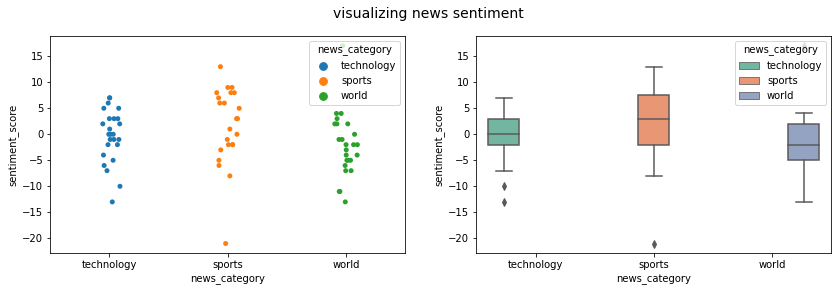

In [38]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(14,4))
sp=sns.stripplot(x='news_category',y='sentiment_score',hue='news_category',data=df,ax=ax1)
bp=sns.boxplot(x='news_category',y='sentiment_score',hue='news_category',data=df,palette='Set2',ax=ax2)
t=f.suptitle('visualizing news sentiment',fontsize=14)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


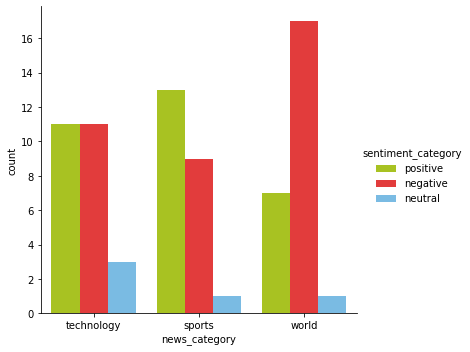

In [39]:
fc=sns.factorplot(x='news_category',hue='sentiment_category',
                  data=df,kind='count',palette={'negative':'#FE2020',
                                                'positive':'#BADD07',
                                                'neutral':'#68BFF5'})

In [40]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 5)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -5)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: The launch of Geo Imaging Satellite GISAT-1 onboard GSLV-F10 has been further delayed by ISRO due to lockdown imposed to prevent coronavirus spread, a report said. Its March 5 launch was previously delayed due to technical reasons but a revised launch date wasn't given. However, sources had said the next launch was planned for April, which now has been delayed.

Most Positive Tech News Article: During a YouTube webinar on Wednesday, Zoom CEO Eric Yuan said the app's team has been working "around the clock" to ensure people are connected. "We're strengthening our commitment to security and privacy practices," he said. Yuan added that a third-party billing engine was needed to process online payments but other than that no user data is shared from meetings.


## Sentiment Analysis with TextBlob
It's also an a sentiment lexicon (in the form XML file) which it leverages to give both Polarity and subjectivity scores.
The scores have a normalized scale as compare to Afinn.
- The polarity score is a float within the range [-1.0,1.0]. 
- The subjectivity is a float within the range [0.0,1.0] 
Where 0.0 is very objective and 1.0 is very subjective.

In [41]:
!pip install Textblob

In [42]:
from textblob import TextBlob

#compute sentiment scores (Polarity) and labels
sentiment_scores_tb=[round(TextBlob(article).sentiment.polarity,3) for article in news_df['clean_text']]
sentiment_category_tb=['positive' if score>0
                       else 'negative' if score < 0
                       else 'neutral'
                       for score in sentiment_scores_tb]

#sentiment statistics per news category
df=pd.DataFrame([list(news_df['news_category']),sentiment_scores_tb,sentiment_category_tb]).T
df.columns=['news_category','sentiment_score','sentiment_category']
df['sentiment_score']=df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                      ...                     
                        count      mean       std  ...    50%    75%    max
news_category                                      ...                     
sports                   23.0  0.149174  0.230567  ...  0.125  0.303  0.558
technology               25.0  0.017200  0.158560  ...  0.000  0.125  0.350
world                    25.0  0.040440  0.134049  ...  0.068  0.115  0.300

[3 rows x 8 columns]

Here,the average sentiment is the most positive in sports and least positive in technology.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


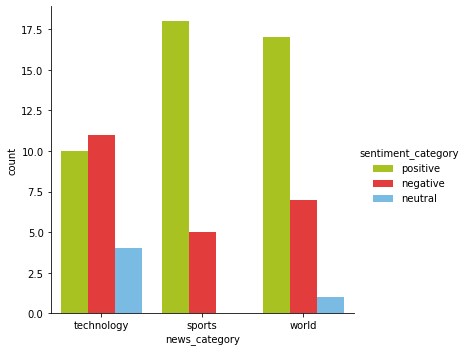

In [43]:
fc=sns.factorplot(x='news_category',hue='sentiment_category',
                  data=df,kind='count',
                  palette={'negative':'#FE2020',
                           'positive':'#BADD07',
                           'neutral':'#68BFF5'})

In [44]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.5)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.296)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

IndexError: ignored

In [0]:
!pip install model_evaluation_utils

We can evaluate and compare between these two models as to how many predicitons are matching and how many are not by leveraging confusion matrix.



In [0]:
''''import model_evaluation_utils as meu
meu.display_confusion_matrix_pretty(true_labels=sentiment_category,
                                    predcited_labels=sentiment_category_tb,
                                    classes=['negative','neutral','positive'])
              '''